# VGAE framework

In [1]:
import torch
from torch_geometric.utils import (negative_sampling, remove_self_loops,
                                   add_self_loops)
from torch_geometric.nn.inits import reset 
EPS = 1e-15
MAX_LOGSTD = 1
 
class InnerProductDecoder(torch.nn.Module):
    r"""The inner product decoder from the `"Variational Graph Auto-Encoders"
    <https://arxiv.org/abs/1611.07308>`_ paper

    .. math::
        \sigma(\mathbf{Z}\mathbf{Z}^{\top})

    where :math:`\mathbf{Z} \in \mathbb{R}^{N \times d}` denotes the latent
    space produced by the encoder."""
    def forward(self, z, edge_index, sigmoid=True):
        r"""Decodes the latent variables :obj:`z` into edge probabilities for
        the given node-pairs :obj:`edge_index`.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        value = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)
        return torch.sigmoid(value) if sigmoid else value


    def forward_all(self, z, sigmoid=True):
        r"""Decodes the latent variables :obj:`z` into a probabilistic dense
        adjacency matrix.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                    the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        adj = torch.matmul(z, z.t())
        return torch.sigmoid(adj) if sigmoid else adj



class GAE(torch.nn.Module):
    r"""The Graph Auto-Encoder model from the
    `"Variational Graph Auto-Encoders" <https://arxiv.org/abs/1611.07308>`_
    paper based on user-defined encoder and decoder models.

    Args:
        encoder (Module): The encoder module.
        decoder (Module, optional): The decoder module. If set to :obj:`None`,
            will default to the
            :class:`torch_geometric.nn.models.InnerProductDecoder`.
            (default: :obj:`None`)
    """
    def __init__(self, encoder, w1=1, w2=1, decoder=None):
        super(GAE, self).__init__()
        self.encoder = encoder
        self.decoder = InnerProductDecoder() if decoder is None else decoder
        self.w1 = w1
        self.w2 = w2
        GAE.reset_parameters(self)

    def reset_parameters(self):
        reset(self.encoder)
        reset(self.decoder)


    def encode(self, *args, **kwargs):
        r"""Runs the encoder and computes node-wise latent variables."""
        return self.encoder(*args, **kwargs)


    def decode(self, *args, **kwargs):
        r"""Runs the decoder and computes edge probabilities."""
        return self.decoder(*args, **kwargs)


    def recon_loss(self, z, pos_edge_index, neg_edge_index=None):
        r"""Given latent variables :obj:`z`, computes the binary cross
        entropy loss for positive edges :oenbj:`pos_edge_index` and negative
        sampled edges.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (LongTensor): The positive edges to train against.
            neg_edge_index (LongTensor, optional): The negative edges to train
                against. If not given, uses negative sampling to calculate
                negative edges. (default: :obj:`None`)
        """

        pos_loss = -torch.log(
            self.decoder(z, pos_edge_index, sigmoid=True) + EPS).sum()

        # Do not include self-loops in negative samples
        pos_edge_index, _ = remove_self_loops(pos_edge_index)
        pos_edge_index, _ = add_self_loops(pos_edge_index)
        if neg_edge_index is None:
            neg_edge_index = negative_sampling(pos_edge_index, z.size(0))
        neg_loss = -torch.log(1 -
                              self.decoder(z, neg_edge_index, sigmoid=True) +
                              EPS).sum()
        N1 = len(-torch.log( self.decoder(z, pos_edge_index, sigmoid=True) + EPS))
        N2 = len(-torch.log(1 - self.decoder(z, neg_edge_index, sigmoid=True) + EPS))

        return (self.w1 * pos_loss + self.w2 * neg_loss) / (N1+N2)


    def test(self, z, pos_edge_index, neg_edge_index):
        r"""Given latent variables :obj:`z`, positive edges
        :obj:`pos_edge_index` and negative edges :obj:`neg_edge_index`,
        computes area under the ROC curve (AUC) and average precision (AP)
        scores.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (LongTensor): The positive edges to evaluate
                against.
            neg_edge_index (LongTensor): The negative edges to evaluate
                against.
        """
        from sklearn.metrics import roc_auc_score, average_precision_score

        pos_y = z.new_ones(pos_edge_index.size(1))
        neg_y = z.new_zeros(neg_edge_index.size(1))
        y = torch.cat([pos_y, neg_y], dim=0)

        pos_pred = self.decoder(z, pos_edge_index, sigmoid=True)
        neg_pred = self.decoder(z, neg_edge_index, sigmoid=True)
        pred = torch.cat([pos_pred, neg_pred], dim=0)
        
        y, pred = y.detach().cpu().numpy(), pred.detach().cpu().numpy()

        return roc_auc_score(y, pred), average_precision_score(y, pred)



class VGAE(GAE):
    r"""The Variational Graph Auto-Encoder model from the
    `"Variational Graph Auto-Encoders" <https://arxiv.org/abs/1611.07308>`_
    paper.

    Args:
        encoder (Module): The encoder module to compute :math:`\mu` and
            :math:`\log\sigma^2`.
        decoder (Module, optional): The decoder module. If set to :obj:`None`,
            will default to the
            :class:`torch_geometric.nn.models.InnerProductDecoder`.
            (default: :obj:`None`)
    """
    def __init__(self, encoder, w1=1, w2=1, decoder=None):
        super(VGAE, self).__init__(encoder, w1, w2, decoder)
        self.w1 = w1
        self.w2 = w2

    def reparametrize(self, mu, logstd):
        if self.training:
            return mu + torch.randn_like(logstd) * torch.exp(logstd)
        else:
            return mu
    
    def encode(self, *args, **kwargs):
        """"""
        self.__mu__, self.__logstd__ = self.encoder(*args, **kwargs)
        self.__logstd__ = self.__logstd__.clamp(max=MAX_LOGSTD)
        z = self.reparametrize(self.__mu__, self.__logstd__)
        return z

    def kl_loss(self, mu=None, logstd=None):
        r"""Computes the KL loss, either for the passed arguments :obj:`mu`
        and :obj:`logstd`, or based on latent variables from last encoding.

        Args:
            mu (Tensor, optional): The latent space for :math:`\mu`. If set to
                :obj:`None`, uses the last computation of :math:`mu`.
                (default: :obj:`None`)
            logstd (Tensor, optional): The latent space for
                :math:`\log\sigma`.  If set to :obj:`None`, uses the last
                computation of :math:`\log\sigma^2`.(default: :obj:`None`)
        """
        mu = self.__mu__ if mu is None else mu
        logstd = self.__logstd__ if logstd is None else logstd.clamp(
            max=MAX_LOGSTD)
        return -0.5 * torch.mean(
            torch.sum(1 + 2 * logstd - mu**2 - logstd.exp()**2, dim=1)) 

# IPF data

## Data class

In [4]:
import torch
from torch.autograd.grad_mode import F
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges

import scipy.sparse as sp
import numpy as np
import networkx as nx

class SimuData():
    """Simulate graph data"""
    def __init__(self, p=0.5, n_node=10, n_graph=30):
        self.n_node = n_node
        self.n_graph = n_graph
        self.p = p

    def simu_adj_wgh(self):
        adj_list = []

        for i in range(self.n_graph):
            ## zero matrix
            A = torch.zeros(self.n_node, self.n_node)
            # first five nodes weights: uniform(0,1)A[:5,:5] = W
            W = torch.rand(5, 5)
            ## symmetric
            i, j = torch.triu_indices(5, 5)
            W[i, j] = W.T[i, j]
            A[:5, :5] = W
            adj_list.append(A)  

        return adj_list

    def simu_adj_diag(self):
        adj_list = []

        for i in range(self.n_graph):
            A = torch.eye(self.n_node)
            adj_list.append(A)  

        return adj_list

    def simu_adj_m(self):
        """generating adjacency matrix"""
        adj_wgh = self.simu_adj_wgh()
        #adj_wgh = self.simu_adj_diag()
        adj_m_list =[]
        for _, adj in enumerate(adj_wgh):
            adj[adj>=1-self.p] = 1
            adj[adj<1-self.p] = 0
            adj_m_list.append(adj)    
        return adj_m_list

    def graph_dataset(self):
        dataset =[]
        simu_adj = self.simu_adj_m()

        for _, adj in enumerate(simu_adj):
            edge_index_temp = sp.coo_matrix(adj)
            indices = np.vstack((edge_index_temp.row, edge_index_temp.col))
            edge_index_A = torch.LongTensor(indices) 
            x = self.get_x_feature()
            data = Data(x=x, edge_index=edge_index_A)
            dataset.append(data)

        return dataset

    def get_x_feature(self):
        x = torch.arange(self.n_node)
        x_onehot = torch.eye(self.n_node)[x,:] 

        return torch.FloatTensor(x_onehot)


class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=False) 
        self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=False)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels, cached=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


transform = T.Compose([
            T.NormalizeFeatures(),
            T.RandomLinkSplit(num_val=0, num_test=0, is_undirected=True,
                            split_labels=True, add_negative_train_samples=False),])

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
import numpy as np
import scipy.sparse as sp
from scipy.sparse import csr_matrix


class LoadData():
    """Load graph data"""
    def __init__(self, file_path, samples, non_orphan_list=None, n_node=38):
        self.samples = samples
        self.file_path = file_path
        self.nSample = len(samples)
        self.non_orphan_list = non_orphan_list
        self.n_node = n_node

    def get_adj_wgh(self):
        """generating adjacency matrix"""
        adj_orig_list =[]
        for sample in self.samples:
            f_name = self.file_path + "/"+ sample
            adj   = np.asarray(pd.read_csv(f_name, index_col = 0, iterator = False))
            adj_orig_list.append(adj)    

        return adj_orig_list

    def get_adj_label(self):
        adj_m = self.get_adj_m()
        adj_label_list =[]
        
        for _, adj in enumerate(adj_m):
            adj_label = adj + sp.eye(adj.shape[0])
            adj_label = sparse_to_tuple(sp.coo_matrix(adj_label))
            #adj_label = sparse_to_tuple(adj_label)
            adj_label = torch.sparse.FloatTensor(torch.LongTensor(adj_label[0].T), 
                            torch.FloatTensor(adj_label[1]), 
                            torch.Size(adj_label[2]))
            adj_label_list.append(adj_label)
        return adj_label_list

    def get_adj_norm(self):
        adj_m = self.get_adj_m()
        adj_norm_list =[]

        for _, adj in enumerate(adj_m):
            adj_norm = preprocess_graph(adj)
            adj_norm = torch.sparse.FloatTensor(torch.LongTensor(adj_norm[0].T), 
                            torch.FloatTensor(adj_norm[1]), 
                            torch.Size(adj_norm[2]))
            adj_norm_list.append(adj_norm)

        return adj_norm_list

    def get_adj_m(self):
        adj_wgh = self.get_adj_wgh()
        adj_m_list =[]
        for _, adj in enumerate(adj_wgh):
            adj[adj > 0] = 1
            for i in range(self.n_node):
                adj[i, i] = 0
            for i in range(self.n_node):
                for j in range(self.n_node):
                    if adj[i, j] == 1:
                        adj[j, i] = 1
            for i in range(self.n_node - 1, -1, -1):
                if i not in self.non_orphan_list:
                    adj = np.delete(adj, (i), axis=0)
                    adj = np.delete(adj, (i), axis=1)
            adj_m_list.append(adj)    
        return adj_m_list

    def get_feature(self):
        """generating feature matrix X"""
        adj_wgh = self.get_adj_wgh()
        x_list = []
        for _, adj in enumerate(adj_wgh):
            x_feature  = adj
            x_feature  = csr_matrix(x_feature)
            x_feature  = sparse_to_tuple(x_feature)
            x_feature  = torch.sparse.FloatTensor(torch.LongTensor(x_feature[0].T), 
                            torch.FloatTensor(x_feature[1]), 
                            torch.Size(x_feature[2]))
            x_list.append(x_feature)
        return x_list

    def get_x_feature(self):
        x = torch.arange(len(self.non_orphan_list))
        x_onehot = torch.eye(len(self.non_orphan_list))[x,:] 

        return torch.FloatTensor(x_onehot)   

    def graph_dataset(self):
        dataset =[]
        simu_adj = self.get_adj_m()

        for _, adj in enumerate(simu_adj):
            edge_index_temp = sp.coo_matrix(adj)
            indices = np.vstack((edge_index_temp.row, edge_index_temp.col))
            edge_index_A = torch.LongTensor(indices) 
            x = self.get_x_feature()
            data = Data(x=x, edge_index=edge_index_A)
            dataset.append(data)
        return dataset


def sparse_to_tuple(sparse_mx):
    if not sp.isspmatrix_coo(sparse_mx):
        sparse_mx = sparse_mx.tocoo()
    coords = np.vstack((sparse_mx.row, sparse_mx.col)).transpose()
    values = sparse_mx.data
    shape = sparse_mx.shape
    return coords, values, shape

def preprocess_graph(adj):
    adj = sp.coo_matrix(adj)
    adj_ = adj + sp.eye(adj.shape[0])
    rowsum = np.array(adj_.sum(1))
    degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5).flatten())
    adj_normalized = adj_.dot(degree_mat_inv_sqrt).transpose().dot(degree_mat_inv_sqrt).tocoo()
    
    return sparse_to_tuple(adj_normalized)

from os import walk

def get_filename(mypath):
    f = []
    for (dirpath, dirnames, filenames) in walk(mypath):
        f.extend(filenames)
        break
    return f

def recover_full_matrix(adj_mat, non_orphan_list):
    df = pd.DataFrame(adj_mat, index=non_orphan_list)
    for i in range(38):
        if i not in df.index:
            line = pd.DataFrame(np.zeros((1,len(non_orphan_list))), index=[i])
            df = pd.concat([df.iloc[:i], line, df.iloc[i:]])
    df = df.T
    df.index = non_orphan_list
    for i in range(38):
        if i not in df.index:
            line = pd.DataFrame(np.zeros((1,38)), index=[i])
            df = pd.concat([df.iloc[:i], line, df.iloc[i:]])
    return np.matrix(df)

def compute_cent(mat):
    return (np.sum(mat, axis=0)/mat.shape[0])

## Load and train ipf data

In [7]:
full_ipf_data = LoadData(samples=get_filename("./vgae_data/result_sig_raw/EGF/IPF"), file_path="./vgae_data/result_sig_raw/EGF/IPF", non_orphan_list=range(38))
full_ipf_input_adj_list = []
full_ipf_input_cent_list = []
n = len(full_ipf_data.get_adj_m())
for i in range(n):
    adj_mat = full_ipf_data.get_adj_m()[i]
    full_ipf_input_adj_list.append(adj_mat)
    full_ipf_input_cent_list.append(compute_cent(adj_mat))
mean_input_cent = np.mean(full_ipf_input_cent_list, axis=0)
np.argwhere(mean_input_cent != 0).T[0]

array([ 0,  1,  3,  4,  5,  6, 12, 13, 18, 19, 20, 21, 24, 27, 30, 31, 32])

In [10]:
# non-orphan nodes
non_orphan_list = np.array([ 0,  1,  3,  4,  5,  6, 12, 13, 18, 19, 20, 21, 24, 27, 30, 31, 32])
ipf_data = LoadData(samples=get_filename("./vgae_data/result_all_raw/EGF/IPF"), file_path="./vgae_data/result_all_raw/EGF/IPF", non_orphan_list=non_orphan_list)
dataset = ipf_data.graph_dataset()

input_adj_list = []
input_cent_list = []
for i in range(n):
    adj_mat = ipf_data.get_adj_m()[i]
    input_adj_list.append(adj_mat)
    input_cent_list.append(compute_cent(adj_mat))
ipf_input_adj_list = input_adj_list
ipf_input_cent_list = input_cent_list

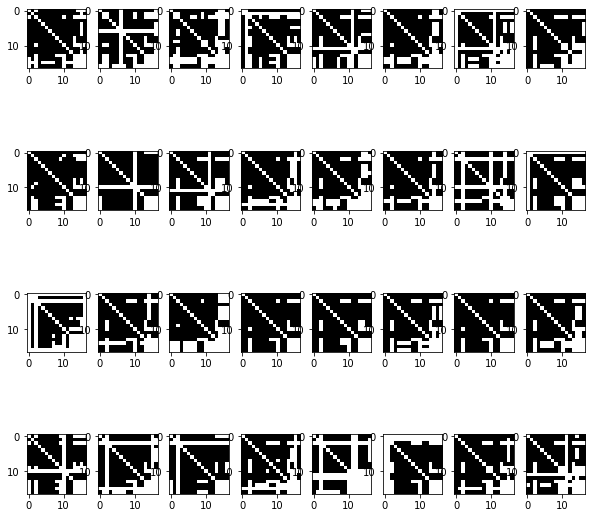

In [11]:
# original adj matrices
n_node = len(non_orphan_list)
temp = np.zeros((2, n_node * n_node))
for i in range(n_node):
    for j in range(n_node):
        temp[0, j + n_node*i] = j
for i in range(n_node):
    for j in range(n_node):
        temp[1, j + n_node*i] = i
edge_index = temp
import matplotlib.pyplot as plt
fig, ax = plt.subplots(4, 8, figsize=(10,10))
for i in range(n):
    plt.subplot(4, 8, i+1)
    plt.imshow(ipf_data.get_adj_m()[i], cmap="Greys")

0tensor(1.3702, grad_fn=<DivBackward0>)
100tensor(0.3425, grad_fn=<DivBackward0>)
200tensor(0.2765, grad_fn=<DivBackward0>)
300tensor(0.2563, grad_fn=<DivBackward0>)
400tensor(0.2398, grad_fn=<DivBackward0>)
500tensor(0.2249, grad_fn=<DivBackward0>)
600tensor(0.2128, grad_fn=<DivBackward0>)
700tensor(0.2038, grad_fn=<DivBackward0>)
800tensor(0.1988, grad_fn=<DivBackward0>)
900tensor(0.1932, grad_fn=<DivBackward0>)
1000tensor(0.1901, grad_fn=<DivBackward0>)
1100tensor(0.1852, grad_fn=<DivBackward0>)
1200tensor(0.1835, grad_fn=<DivBackward0>)
1300tensor(0.1794, grad_fn=<DivBackward0>)
1400tensor(0.1760, grad_fn=<DivBackward0>)
1500tensor(0.1718, grad_fn=<DivBackward0>)
1600tensor(0.1685, grad_fn=<DivBackward0>)
1700tensor(0.1652, grad_fn=<DivBackward0>)
1800tensor(0.1625, grad_fn=<DivBackward0>)
1900tensor(0.1599, grad_fn=<DivBackward0>)
2000tensor(0.1587, grad_fn=<DivBackward0>)
2100tensor(0.1556, grad_fn=<DivBackward0>)
2200tensor(0.1552, grad_fn=<DivBackward0>)
2300tensor(0.1545, grad

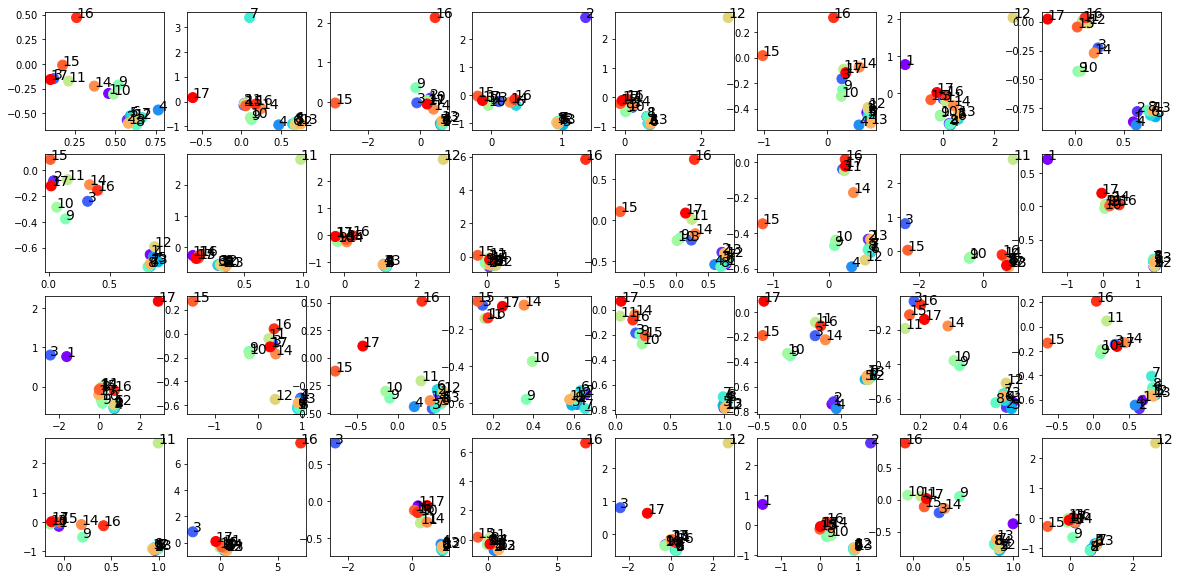

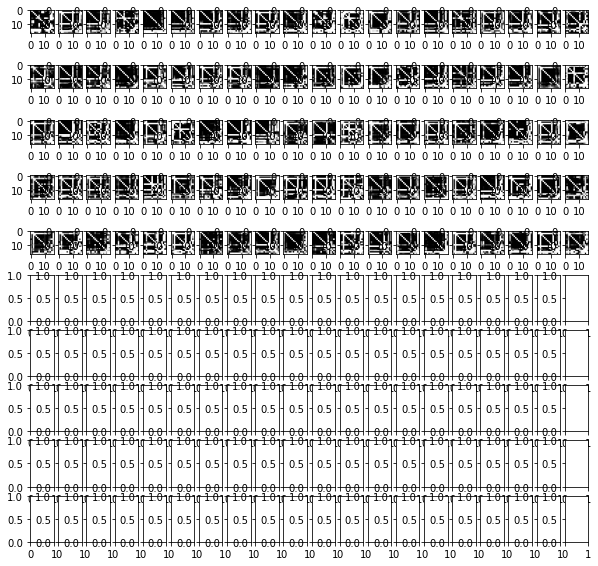

In [18]:
out_channels = 10
n_node = len(non_orphan_list)
num_features = n_node
for w1 in range(1, 2):
    for w2 in range(1, 2):
        VGAE_Encoder = Encoder(num_features, out_channels)
        model = VGAE(encoder = VGAE_Encoder, w1=w1, w2=w2)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
        epochs = 5000

        for epoch in range(epochs):
            loss_total = 0
            optimizer.zero_grad()

            for i in range(len(dataset)):
                train_data, val_data, test_data = transform(dataset[i])
                z = model.encode(train_data.x, train_data.edge_index)
                loss = model.recon_loss(z, train_data.edge_index) 
                loss = loss + 0.001 * 1/n_node * model.kl_loss()
                loss_total += loss

            loss_avg = loss_total/len(dataset)
            loss_avg.backward()
            optimizer.step()
            if epoch % 100 ==0:
                print(str(epoch)+str(loss_avg))
            # get mu and logstd 

        mu_list_in_data = []
        logstd_list_in_data = []
        for i in range(len(dataset)):
            train_data, val_data, test_data = transform(dataset[i])
            mu = model.encode(train_data.x, train_data.edge_index)
            mu_list_in_data.append(np.asarray(mu.detach()))

        mu_list_reshape = []
        n = len(dataset)
        for i in range(n):
            mu_list_reshape.append(mu_list_in_data[i].reshape((out_channels * n_node)))

        # input data scatter 
        import matplotlib.pyplot as plt
        def plot_mu_graph(mu):
            n_node = mu.shape[0]
            annotations = [str(i+1) for i in range(n_node)]
            colors = plt.cm.rainbow(np.linspace(0, 1, n_node))
            plt.scatter(mu[:,0],mu[:,1],c=colors, s=100)

            for i, label in enumerate(annotations):
                plt.annotate(label, (mu[i,0], mu[i,1]), fontsize=14)


        plt.subplots(figsize=(20,10))

        for graph_i in range(n):
            plt.subplot(4, 8, graph_i+1)
            plot_mu_graph(mu_list_in_data[graph_i])
        # Gaussian distribution for generating mu

        import scipy.stats as stats
        data_mu = np.zeros((n, out_channels * n_node))
        for i in range(n):
            data_mu[i, :] = mu_list_reshape[i]

        from sklearn.mixture import GaussianMixture

        gm_mu = GaussianMixture(n_components=1, random_state=0).fit(data_mu)
        gm_mu.weights_[0] = 1  

        # got mean and cov for mu generating distribution
        means_normal = gm_mu.means_
        cov_normal = gm_mu.covariances_
        means_normal = np.asarray(means_normal.tolist()[0])
        cov_normal = np.asarray(cov_normal.tolist()[0])

        def sample_adj_mat(filter_option=True, filter_value=0.75, filter_eye=True):
            model.__mu__ = torch.from_numpy((np.random.multivariate_normal(mean=means_normal,cov=cov_normal)).reshape((n_node,out_channels)))
            z = model.__mu__
            model.decode(z, edge_index)
            adj_mat = np.zeros((n_node, n_node))
            for i in range(n_node*n_node):
                adj_mat[int(edge_index[0, i]), int(edge_index[1, i])] = (model.decode(z, edge_index)[i].detach().numpy()).item()
            if filter_option==True:   
                adj_mat[adj_mat < filter_value] = 0
                adj_mat[adj_mat >= filter_value] = 1
            if filter_eye:
                for i in range(adj_mat.shape[0]):
                    adj_mat[i,i]=0
            return adj_mat, model.__mu__
        
        # generate adjacency matrices

        output_cent_list = []
        mu_list = []
        output_adj_list = []
        gen_size = 100
        fig, ax = plt.subplots(10, 20, figsize=(10,10))

        for i in range(gen_size):
            adj_mat, mu_sample = sample_adj_mat(filter_option=False, filter_value=0, filter_eye=True)
            output_adj_list.append(adj_mat)
            output_cent_list.append(compute_cent(adj_mat))
            if i<200:
                plt.subplot(10, 20, i+1)
                plt.imshow(adj_mat, cmap="Greys")
        ipf_output_cent_list = output_cent_list
        ipf_output_adj_list = output_adj_list
        
        # conpute input centralities
        input_adj_list = []
        input_cent_list = []
        for i in range(n):
            adj_mat = ipf_data.get_adj_m()[i]
            input_adj_list.append(adj_mat)
            input_cent_list.append(compute_cent(adj_mat))
            
        from scipy import stats
        res = stats.ttest_ind(output_cent_list, input_cent_list, 
                              equal_var=True, axis=0)
        print(np.mean(res.pvalue>=0.05/19))

In [13]:
# os.chdir('C:\\Users\\Ji Qi\\Documents\\GitHub\\ST-Aim3')
# os.getcwd()
PATH = "./model/"+str(out_channels)+'_dim_vgae_model_for_ipfdata.pth'
torch.save(model, PATH)

model = torch.load(PATH)
model.eval()

VGAE(
  (encoder): Encoder(
    (conv1): GCNConv(38, 20)
    (conv_mu): GCNConv(20, 10)
    (conv_logstd): GCNConv(20, 10)
  )
  (decoder): InnerProductDecoder()
)

## Generate IPF matrices

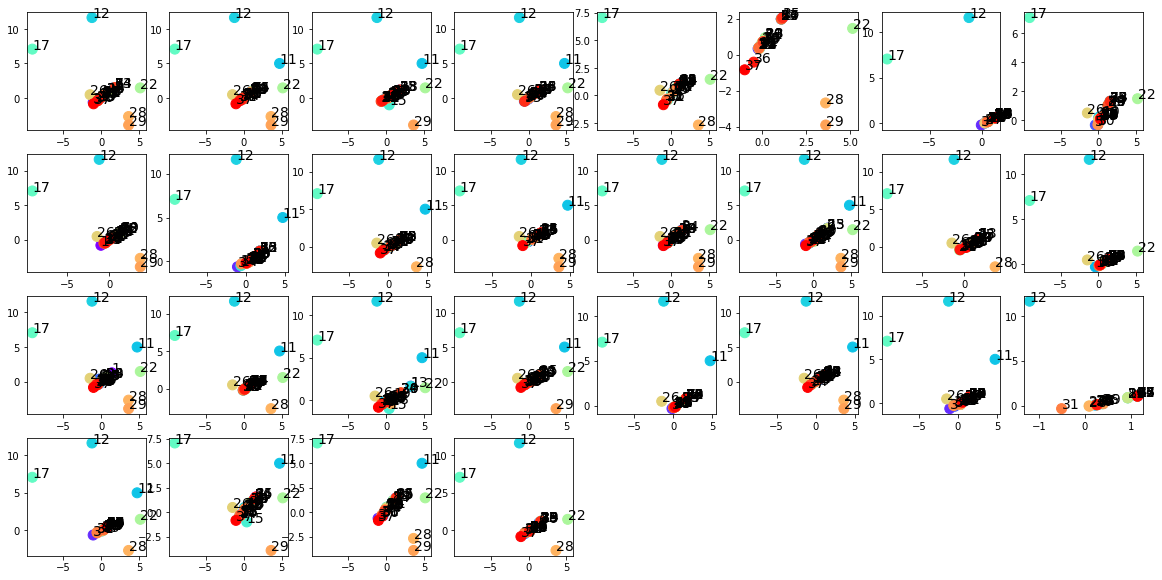

In [156]:
# get mu and logstd 

mu_list_in_data = []
logstd_list_in_data = []
for i in range(len(dataset)):
    train_data, val_data, test_data = transform(dataset[i])
    mu = model.encode(train_data.x, train_data.edge_index)
    mu_list_in_data.append(np.asarray(mu.detach()))

mu_list_reshape = []
n = len(dataset)
for i in range(n):
    mu_list_reshape.append(mu_list_in_data[i].reshape((out_channels * n_node)))

# input data scatter 
import matplotlib.pyplot as plt
def plot_mu_graph(mu):
    n_node = mu.shape[0]
    annotations = [str(i+1) for i in range(n_node)]
    colors = plt.cm.rainbow(np.linspace(0, 1, n_node))
    plt.scatter(mu[:,0],mu[:,1],c=colors, s=100)
    
    for i, label in enumerate(annotations):
        plt.annotate(label, (mu[i,0], mu[i,1]), fontsize=14)

        
plt.subplots(figsize=(20,10))

for graph_i in range(n):
    plt.subplot(4, 8, graph_i+1)
    plot_mu_graph(mu_list_in_data[graph_i])
# Gaussian distribution for generating mu

import scipy.stats as stats
data_mu = np.zeros((n, out_channels * n_node))
for i in range(n):
    data_mu[i, :] = mu_list_reshape[i]

from sklearn.mixture import GaussianMixture

gm_mu = GaussianMixture(n_components=1, random_state=0).fit(data_mu)
gm_mu.weights_[0] = 1  

# got mean and cov for mu generating distribution
means_normal = gm_mu.means_
cov_normal = gm_mu.covariances_
means_normal = np.asarray(means_normal.tolist()[0])
cov_normal = np.asarray(cov_normal.tolist()[0])

def sample_adj_mat(filter_option=True, filter_value=0.75, filter_eye=True):
    model.__mu__ = torch.from_numpy((np.random.multivariate_normal(mean=means_normal,cov=cov_normal)).reshape((n_node,out_channels)))
    z = model.__mu__
    model.decode(z, edge_index)
    adj_mat = np.zeros((n_node, n_node))
    for i in range(n_node*n_node):
        adj_mat[int(edge_index[0, i]), int(edge_index[1, i])] = (model.decode(z, edge_index)[i].detach().numpy()).item()
    if filter_option==True:   
        adj_mat[adj_mat < filter_value] = 0
        adj_mat[adj_mat >= filter_value] = 1
    if filter_eye:
        for i in range(adj_mat.shape[0]):
            adj_mat[i,i]=0
    return adj_mat, model.__mu__

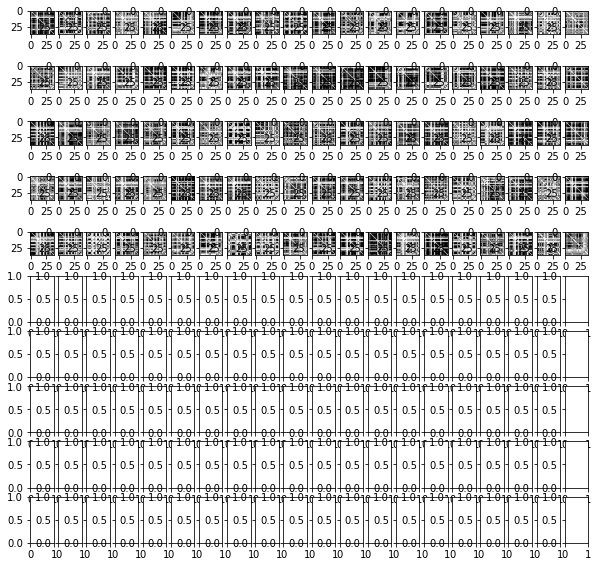

In [157]:
# generate adjacency matrices

output_cent_list = []
mu_list = []
output_adj_list = []
gen_size = 100
fig, ax = plt.subplots(10, 20, figsize=(10,10))

for i in range(gen_size):
    adj_mat, mu_sample = sample_adj_mat(filter_option=False, filter_value=0, filter_eye=True)
    output_adj_list.append(adj_mat)
    output_cent_list.append(compute_cent(adj_mat))
    if i<200:
        plt.subplot(10, 20, i+1)
        plt.imshow(adj_mat, cmap="Greys")
ipf_output_cent_list = output_cent_list
ipf_output_adj_list = output_adj_list

In [158]:
# conpute input centralities
input_adj_list = []
input_cent_list = []
for i in range(n):
    adj_mat = ipf_data.get_adj_m()[i]
    input_adj_list.append(adj_mat)
    input_cent_list.append(compute_cent(adj_mat))

In [159]:
# t-test between raw input and output 
from scipy import stats
res = stats.ttest_ind(output_cent_list, input_cent_list, 
                      equal_var=True, axis=0)
display(res)
pd.DataFrame(np.around(res.pvalue, decimals=3))
res.pvalue>=0.05/19


Ttest_indResult(statistic=array([ 2.006,  2.548,  8.076,  7.802,  2.965,  2.759,  2.778,  6.372,
        7.819,  7.297,  3.335,  3.357,  3.026,  3.099,  9.906,  8.298,
        2.921,  10.308,  6.422,  7.656,  7.822,  3.288,  6.282,  5.186,
        3.496,  3.666,  19.826,  4.694,  2.948,  8.892,  7.937,  8.808,
        2.877,  4.947,  2.786,  4.710,  5.844]), pvalue=array([ 0.047,  0.012,  0.000,  0.000,  0.004,  0.007,  0.006,  0.000,
        0.000,  0.000,  0.001,  0.001,  0.003,  0.002,  0.000,  0.000,
        0.004,  0.000,  0.000,  0.000,  0.000,  0.001,  0.000,  0.000,
        0.001,  0.000,  0.000,  0.000,  0.004,  0.000,  0.000,  0.000,
        0.005,  0.000,  0.006,  0.000,  0.000]))

array([ True,  True, False, False,  True,  True,  True, False, False,
       False, False, False,  True, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False,  True, False,  True, False,
       False])

In [160]:
pvaluedf = pd.DataFrame(res.pvalue)
pvaluedf

,0
0,4.700979e-02
1,1.203059e-02
2,4.621871e-13
3,2.008079e-12
4,3.621988e-03
5,6.658499e-03
6,6.309253e-03
7,3.199277e-09
8,1.841658e-12
9,2.902349e-11


In [ ]:
pd.DataFrame(np.around(res.pvalue, decimals=3))

## t-test between IPF input and output

In [111]:
# Find the best filter value and t-test
import copy

for i in range(100):
    adj_mat, mu_sample = sample_adj_mat(filter_option=False, filter_value=0, filter_eye=True)
    output_adj_list.append(adj_mat)
    output_cent_list.append(compute_cent(adj_mat))
    adj_mat_list.append(adj_mat)
    mu_list.append(mu_sample.detach().numpy())

array([4.99365377e-03, 2.44599241e-02, 9.82659289e-01, 8.39641735e-15,
       1.46003867e-09, 5.86593913e-08, 8.39775673e-04, 1.27753946e-06,
       2.47687072e-03, 2.15897161e-01, 5.09968093e-01, 2.32289784e-01,
       1.49831529e-03, 6.85211183e-04, 4.34555440e-03, 8.90206899e-01,
       5.37535831e-01])

In [133]:
adj_mat_list[1].shape

(38, 38)

In [166]:
not_significant_num = []
for fv in np.linspace(0.3,0.8,20):
    output_adj_list = []
    output_cent_list = []
    adj_mat_list = []
    mu_list = []
    for i in range(30):
        adj_mat, mu_sample = sample_adj_mat(filter_value=fv, filter_eye=True)
        output_adj_list.append(adj_mat)
        output_cent_list.append(compute_cent(adj_mat))
        adj_mat_list.append(adj_mat)
        mu_list.append(mu_sample.detach().numpy())
    res = stats.ttest_ind(output_cent_list, input_cent_list, equal_var=True, axis=0)
    not_significant_num.append(np.sum(res.pvalue>0.05/19))

[1, 2]

In [126]:
compute_cent(adj_mat_temp)

array([ 1.000,  1.000,  1.000,  1.000,  1.000,  1.000,  1.000,  1.000,
        1.000,  1.000,  1.000,  1.000,  1.000,  1.000,  1.000,  1.000,
        1.000])

Text(0, 0.5, 'non-significant number')

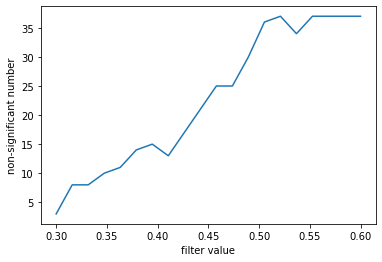

In [169]:
plt.plot(np.linspace(0.3,0.6,20), not_significant_num)
plt.xlabel("filter value")
plt.ylabel("non-significant number")

In [ ]:
# t-test between IPF input and output

output_adj_list = []
output_cent_list = []
adj_mat_list = []
mu_list = []
for i in range(100):
    adj_mat, mu_sample = sample_adj_mat(filter_value=0.7, filter_eye=True)
    output_adj_list.append(adj_mat)
    output_cent_list.append(compute_cent(adj_mat))
    adj_mat_list.append(adj_mat)
    mu_list.append(mu_sample.detach().numpy())
input_adj_list = []
input_cent_list = []
for i in range(32):
    adj_mat = ipf_data.get_adj_m()[i]
    input_adj_list.append(adj_mat)
    input_cent_list.append(compute_cent(adj_mat))
res = stats.ttest_ind(output_cent_list, input_cent_list, 
                  equal_var=True, axis=0)
np.sum(res.pvalue>0.05/19)

In [82]:
# t-test between IPF input and output vs. generation sizes

output_adj_list = []
output_cent_list = []
adj_mat_list = []
mu_list = []
fv = 0.7
p_value_table = pd.DataFrame()
for gen_size in range(10, 1000, 50):
    for i in range(gen_size):
        adj_mat, mu_sample = sample_adj_mat(filter_option=True, filter_value=fv, filter_eye=True)
        output_adj_list.append(adj_mat)
        output_cent_list.append(compute_cent(adj_mat))
        mu_list.append(mu_sample.detach().numpy())
    input_adj_list = []
    input_cent_list = []
    for i in range(32):
        adj_mat = ipf_data.get_adj_m()[i]
        input_adj_list.append(adj_mat)
        input_cent_list.append(compute_cent(adj_mat))
    res = stats.ttest_ind(output_cent_list, input_cent_list, 
                      equal_var=True, axis=0)
    p_value_table = pd.concat([p_value_table, pd.DataFrame(res.pvalue)], axis=1)

In [49]:
# recover to sparse matrices
ipf_output_cent_list = output_cent_list
ipf_output_adj_list = output_adj_list

full_ipf_output_adj_list = []
full_ipf_output_cent_list = []

for i in range(gen_size):
    full_ipf_output_adj_list.append(recover_full_matrix(output_adj_list[i], non_orphan_list=non_orphan_list))
    full_ipf_output_cent_list.append(compute_cent(recover_full_matrix(output_adj_list[i], non_orphan_list=non_orphan_list)))

## t-test between IPF input and control input

In [ ]:
raw_ipf_data = LoadData(samples=get_filename("./new_ipfdata"), file_path="./new_ipfdata", non_orphan_list=range(38))
raw_ctrl_data = LoadData(samples=get_filename("./new_ctrldata"), file_path="./new_ctrldata", non_orphan_list=range(38))

In [ ]:
raw_ipf_cent_list = []
raw_ctrl_cent_list = []
for i in range(len(raw_ipf_data.get_adj_m())):
    adj_mat = raw_ipf_data.get_adj_m()[i]
    raw_ipf_cent_list.append(compute_cent(adj_mat))
    
for i in range(len(raw_ctrl_data.get_adj_m())):
    adj_mat = raw_ctrl_data.get_adj_m()[i]
    raw_ctrl_cent_list.append(compute_cent(adj_mat))
    
res = stats.ttest_ind(raw_ctrl_cent_list, raw_ipf_cent_list, 
                      equal_var=True, axis=0)
display(res)
np.around(res.pvalue, decimals=3)
np.argwhere(res.pvalue<0.05/19)

In [ ]:
pd.DataFrame(np.around(res.pvalue, decimals=3)).T

## Spectrum

In [ ]:
import numpy.linalg as linalg
output_spectrum = []
input_spectrum = []
for adj in output_adj_list:
    lam, v = linalg.eig(adj)
    output_spectrum.append(lam)
for adj in input_adj_list:
    lam, v = linalg.eig(adj)
    input_spectrum.append(lam) 

In [ ]:
def compute_spectrum_distance(lam1, lam2):
    return linalg.norm((lam1-lam2), 2)

In [ ]:
spectrum_distance_matrix = np.empty((len(input_adj_list), len(output_adj_list)))
for i in range((len(input_adj_list))):
    for j in range(len(output_adj_list)):
        spectrum_distance_matrix[i, j] = compute_spectrum_distance(input_spectrum[i], output_spectrum[j])

In [ ]:
G0_G1_distance = spectrum_distance_matrix.flatten()

In [ ]:
G0_distance = input_spectrum_distance_matrix.flatten()
G0_mean = np.mean(G0_distance)
G0_var = np.var(G0_distance)

In [ ]:
G0_G1_mean = np.mean(G0_G1_distance)
G0_G1_mean

In [ ]:
(G0_G1_mean - G0_mean) ** 2 / (G0_var)

In [ ]:
G0_mean

In [ ]:
G0_var

In [ ]:
np.around(np.mean(np.vstack(input_cent_list), axis=0) - np.mean(np.vstack(output_cent_list), axis=0), decimals=2)

In [ ]:
import numpy.linalg as linalg
output_spectrum = []
input_spectrum = []
input_adj_list = raw_ctrl_data.get_adj_m()
output_adj_list = raw_ipf_data.get_adj_m()
for adj in raw_ipf_data.get_adj_m():
    lam, v = linalg.eig(adj)
    output_spectrum.append(lam)
for adj in raw_ctrl_data.get_adj_m():
    lam, v = linalg.eig(adj)
    input_spectrum.append(lam) 
spectrum_distance_matrix = np.empty((len(input_adj_list), len(output_adj_list)))
for i in range((len(input_adj_list))):
    for j in range(len(output_adj_list)):
        spectrum_distance_matrix[i, j] = compute_spectrum_distance(raw_ipf_data.get_adj_m()[i], raw_ipf_data.get_adj_m()[j])
spectrum_distance_matrix.shape

## Data Summary

In [ ]:
ipf_output_cent_list

ipf_output_adj_list 

ipf_input_adj_list 

ipf_input_cent_list 

full_ipf_input_adj_list 

full_ipf_input_cent_list 

full_ipf_output_adj_list 

full_ipf_output_cent_list 

In [ ]:
full_ctrl_input_adj_list
full_ctrl_input_cent_list
ctrl_input_adj_list
ctrl_input_cent_list
full_ctrl_output_adj_list 
full_ctrl_output_cent_list 
ctrl_output_cent_list
ctrl_output_adj_list 

# Ctrl data

## Load and train Ctrl data

In [51]:
full_ctrl_data = LoadData(samples=get_filename("./new_ctrldata"), file_path="./new_ctrldata", non_orphan_list=range(38))
full_ctrl_input_adj_list = []
full_ctrl_input_cent_list = []
for i in range(28):
    adj_mat = full_ctrl_data.get_adj_m()[i]
    full_ctrl_input_adj_list.append(adj_mat)
    full_ctrl_input_cent_list.append(compute_cent(adj_mat))
mean_input_cent = np.mean(full_ctrl_input_cent_list, axis=0)
np.argwhere(mean_input_cent != 0).T[0]

array([ 1,  2,  3,  4,  5,  8,  9, 13, 14, 17, 19, 20, 21, 22, 23, 25, 30,
       31, 32])

In [52]:
# non-orphan nodes
non_orphan_list = np.array([ 1,  2,  3,  4,  5,  8,  9, 13, 14, 17, 19, 20, 21, 22, 23, 25, 30, 31, 32])
ctrl_data = LoadData(samples=get_filename("./new_ctrldata"), file_path="./new_ctrldata", non_orphan_list=non_orphan_list)
dataset = ctrl_data.graph_dataset()
print(len(ctrl_data.get_adj_m()))

input_adj_list = []
input_cent_list = []
for i in range(28):
    adj_mat = ctrl_data.get_adj_m()[i]
    input_adj_list.append(adj_mat)
    input_cent_list.append(compute_cent(adj_mat))
mean_input_cent = np.mean(input_cent_list, axis=0)
np.argwhere(mean_input_cent != 0).T[0]

ctrl_input_adj_list = input_adj_list
ctrl_input_cent_list = input_cent_list

28


In [112]:
np.mean(ctrl_input_cent_list)

0.3300356153541749

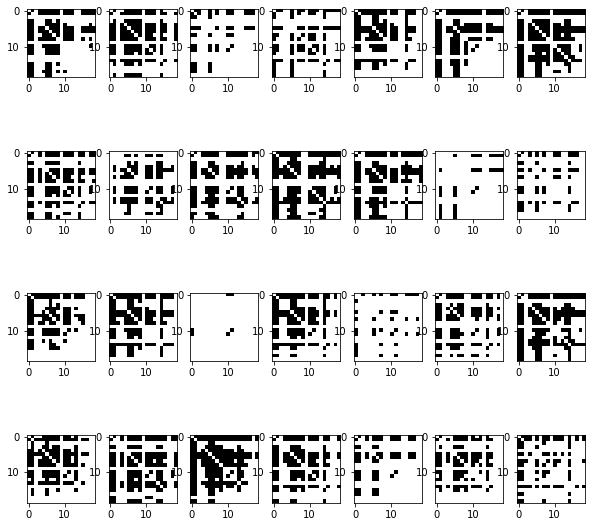

In [53]:
# original adj matrices

import matplotlib.pyplot as plt
fig, ax = plt.subplots(4, 7, figsize=(10,10))
for i in range(28):
    plt.subplot(4, 7, i+1)
    plt.imshow(ctrl_data.get_adj_m()[i], cmap="Greys")

In [117]:
out_channels = 2
n_node = len(non_orphan_list)
num_features = n_node

VGAE_Encoder = Encoder(num_features, out_channels)
model = VGAE(encoder = VGAE_Encoder, w1=1, w2=10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
epochs = 2000

for epoch in range(epochs):
    loss_total = 0
    optimizer.zero_grad()
    
    for i in range(len(dataset)):
        train_data, val_data, test_data = transform(dataset[i])
        z = model.encode(train_data.x, train_data.edge_index)
        loss = model.recon_loss(z, train_data.edge_index) 
        loss = loss + 1/n_node * model.kl_loss()
        loss_total += loss

    loss_avg = loss_total/len(dataset)
    loss_avg.backward()
    optimizer.step()
    if epoch % 100 ==0:
        print(str(epoch)+str(loss_avg))

0tensor(9.9414, grad_fn=<DivBackward0>)
100tensor(7.7362, grad_fn=<DivBackward0>)
200tensor(7.1540, grad_fn=<DivBackward0>)
300tensor(6.8463, grad_fn=<DivBackward0>)
400tensor(6.5024, grad_fn=<DivBackward0>)
500tensor(6.4266, grad_fn=<DivBackward0>)
600tensor(6.3712, grad_fn=<DivBackward0>)
700tensor(6.2147, grad_fn=<DivBackward0>)
800tensor(6.2363, grad_fn=<DivBackward0>)
900tensor(6.1432, grad_fn=<DivBackward0>)
1000tensor(6.0589, grad_fn=<DivBackward0>)
1100tensor(6.1297, grad_fn=<DivBackward0>)
1200tensor(6.0267, grad_fn=<DivBackward0>)
1300tensor(5.9114, grad_fn=<DivBackward0>)
1400tensor(5.8512, grad_fn=<DivBackward0>)
1500tensor(5.8914, grad_fn=<DivBackward0>)
1600tensor(5.8734, grad_fn=<DivBackward0>)
1700tensor(5.8781, grad_fn=<DivBackward0>)
1800tensor(5.7611, grad_fn=<DivBackward0>)
1900tensor(5.8997, grad_fn=<DivBackward0>)


In [54]:
# os.chdir('C:\\Users\\Ji Qi\\Documents\\GitHub\\ST-Aim3')
# os.getcwd()
PATH = str(out_channels)+'_dim_vgae_model_for_ctrldata.pth'
# torch.save(model, PATH)

model = torch.load(PATH)
model.eval()

VGAE(
  (encoder): Encoder(
    (conv1): GCNConv(19, 4)
    (conv_mu): GCNConv(4, 2)
    (conv_logstd): GCNConv(4, 2)
  )
  (decoder): InnerProductDecoder()
)

## Generate Ctrl matrices

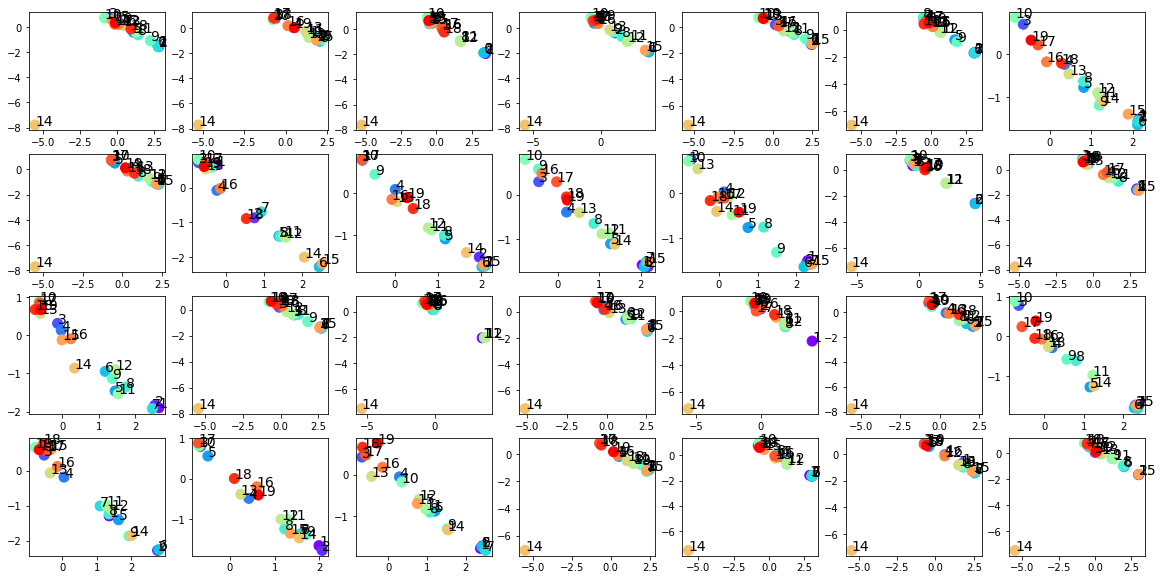

In [118]:
# get mu and logstd 

mu_list_in_data = []
logstd_list_in_data = []
for i in range(len(dataset)):
    train_data, val_data, test_data = transform(dataset[i])
    mu = model.encode(train_data.x, train_data.edge_index)
    mu_list_in_data.append(np.asarray(mu.detach()))

mu_list_reshape = []
n = len(dataset)
for i in range(n):
    mu_list_reshape.append(mu_list_in_data[i].reshape((out_channels * n_node)))

# input data scatter 
import matplotlib.pyplot as plt
def plot_mu_graph(mu):
    n_node = mu.shape[0]
    annotations = [str(i+1) for i in range(n_node)]
    colors = plt.cm.rainbow(np.linspace(0, 1, n_node))
    plt.scatter(mu[:,0],mu[:,1],c=colors, s=100)
    
    for i, label in enumerate(annotations):
        plt.annotate(label, (mu[i,0], mu[i,1]), fontsize=14)

        
plt.subplots(figsize=(20,10))

for graph_i in range(n):
    plt.subplot(4, 7, graph_i+1)
    plot_mu_graph(mu_list_in_data[graph_i])
# Gaussian distribution for generating mu

import scipy.stats as stats
data_mu = np.zeros((n, out_channels * n_node))
for i in range(n):
    data_mu[i, :] = mu_list_reshape[i]

from sklearn.mixture import GaussianMixture

gm_mu = GaussianMixture(n_components=1, random_state=0).fit(data_mu)
gm_mu.weights_[0] = 1  

# got mean and cov for mu generating distribution
means_normal = gm_mu.means_
cov_normal = gm_mu.covariances_
means_normal = np.asarray(means_normal.tolist()[0])
cov_normal = np.asarray(cov_normal.tolist()[0])

def sample_adj_mat(filter_option=True, filter_value=0.75, filter_eye=True):
    model.__mu__ = torch.from_numpy((np.random.multivariate_normal(mean=means_normal,cov=cov_normal)).reshape((n_node,out_channels)))
    z = model.__mu__
    model.decode(z, edge_index)
    adj_mat = np.zeros((n_node, n_node))
    for i in range(n_node*n_node):
        adj_mat[int(edge_index[0, i]), int(edge_index[1, i])] = (model.decode(z, edge_index)[i].detach().numpy()).item()
    if filter_option==True:   
        adj_mat[adj_mat < filter_value] = 0
        adj_mat[adj_mat >= filter_value] = 1
    if filter_eye:
        for i in range(adj_mat.shape[0]):
            adj_mat[i,i]=0
    return adj_mat, model.__mu__

In [57]:
len(ctrl_output_adj_list)

2000

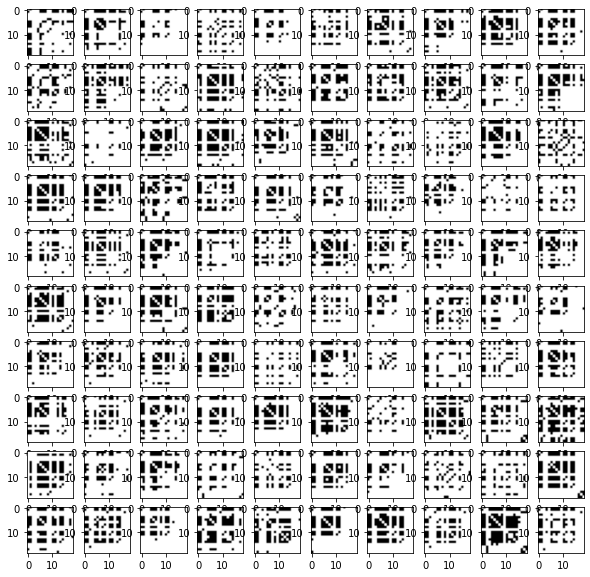

In [121]:
# generate adjacency matrices

output_cent_list = []
mu_list = []
output_adj_list = []
gen_size = 100
fig, ax = plt.subplots(10, 10, figsize=(10,10))

for i in range(gen_size):
    adj_mat, mu_sample = sample_adj_mat(filter_option=True, filter_value=0.75, filter_eye=True)
    output_adj_list.append(adj_mat)
    output_cent_list.append(compute_cent(adj_mat))
    if i<100:
        plt.subplot(10, 10, i+1)
        plt.imshow(adj_mat, cmap="Greys")
    
ctrl_output_adj_list = output_adj_list
ctrl_output_cent_list = output_cent_list

In [58]:
# conpute input centralities
input_adj_list = []
input_cent_list = []
for i in range(n):
    adj_mat = ctrl_data.get_adj_m()[i]
    input_adj_list.append(adj_mat)
    input_cent_list.append(compute_cent(adj_mat))

In [59]:
# t-test between raw input and output 
from scipy import stats
res = stats.ttest_ind(output_cent_list, input_cent_list, 
                      equal_var=True, axis=0)
display(res)
pd.DataFrame(np.around(res.pvalue, decimals=3))

Ttest_indResult(statistic=array([-6.28771922e+00, -6.93185887e+00,  1.34441241e+00, -9.58362388e-02,
       -3.14126382e+00, -6.16539821e+00, -4.99620425e+00, -1.68401777e+00,
       -3.27529565e+00,  2.44428355e+00, -1.42689861e+00, -1.53082736e-03,
       -1.13816914e+00, -2.14433428e+00, -3.89685968e+00,  1.36606901e+00,
        7.47206353e-01,  2.41209796e-01, -1.34330429e-01]), pvalue=array([3.93476644e-10, 5.56243020e-12, 1.78965568e-01, 9.23660113e-01,
       1.70649997e-03, 8.46180377e-10, 6.34848727e-07, 9.23322739e-02,
       1.07331357e-03, 1.45987393e-02, 1.53763211e-01, 9.98778728e-01,
       2.55184433e-01, 3.21247668e-02, 1.00613551e-04, 1.72068915e-01,
       4.55025717e-01, 8.09416927e-01, 8.93154635e-01]))

,0
0,0.000
1,0.000
2,0.179
3,0.924
4,0.002
5,0.000
6,0.000
7,0.092
8,0.001
9,0.015


## t-test between Ctrl input and output

In [19]:
# Find the best filter value and t-test

not_significant_num = []
gen_size = 100
for fv in np.linspace(0.6,0.8,21):
    output_adj_list = []
    output_cent_list = []
    adj_mat_list = []
    mu_list = []
    for i in range(gen_size):
        adj_mat, mu_sample = sample_adj_mat(filter_value=fv, filter_eye=True)
        output_adj_list.append(adj_mat)
        output_cent_list.append(compute_cent(adj_mat))
        adj_mat_list.append(adj_mat)
        mu_list.append(mu_sample.detach().numpy())
    res = stats.ttest_ind(output_cent_list, input_cent_list, equal_var=True, axis=0)
    not_significant_num.append(np.sum(res.pvalue>0.05/38))
    


In [20]:
not_significant_num

[13,
 13,
 14,
 15,
 15,
 16,
 16,
 16,
 17,
 17,
 17,
 17,
 19,
 18,
 18,
 19,
 19,
 19,
 19,
 19,
 18]

In [69]:
# t-test between Ctrl input and output

output_adj_list = []
output_cent_list = []
adj_mat_list = []
mu_list = []
gen_size = 100
for i in range(gen_size):
    adj_mat, mu_sample = sample_adj_mat(filter_value=0.7, filter_eye=True)
    output_adj_list.append(adj_mat)
    output_cent_list.append(compute_cent(adj_mat))
    adj_mat_list.append(adj_mat)
    mu_list.append(mu_sample.detach().numpy())
input_adj_list = []
input_cent_list = []
for i in range(n):
    adj_mat = ctrl_data.get_adj_m()[i]
    input_adj_list.append(adj_mat)
    input_cent_list.append(compute_cent(adj_mat))
res = stats.ttest_ind(output_cent_list, input_cent_list, 
                  equal_var=True, axis=0)
np.sum(res.pvalue>0.05/19)

17

In [82]:
# t-test between Ctrl input and output vs. generation sizes

output_adj_list = []
output_cent_list = []
adj_mat_list = []
mu_list = []
fv = 0.7
p_value_table = pd.DataFrame()
for gen_size in range(10, 1000, 50):
    for i in range(gen_size):
        adj_mat, mu_sample = sample_adj_mat(filter_option=True, filter_value=fv, filter_eye=True)
        output_adj_list.append(adj_mat)
        output_cent_list.append(compute_cent(adj_mat))
        mu_list.append(mu_sample.detach().numpy())
    input_adj_list = []
    input_cent_list = []
    for i in range(28):
        adj_mat = ctrl_data.get_adj_m()[i]
        input_adj_list.append(adj_mat)
        input_cent_list.append(compute_cent(adj_mat))
    res = stats.ttest_ind(output_cent_list, input_cent_list, 
                      equal_var=True, axis=0)
    p_value_table = pd.concat([p_value_table, pd.DataFrame(res.pvalue)], axis=1)

In [60]:
# recover to sparse matrices

full_ctrl_output_adj_list = []
full_ctrl_output_cent_list = []
for i in range(gen_size):
    full_ctrl_output_adj_list.append(recover_full_matrix(output_adj_list[i], non_orphan_list=non_orphan_list))
    full_ctrl_output_cent_list.append(compute_cent(recover_full_matrix(output_adj_list[i], non_orphan_list=non_orphan_list)))

## t-test beteen IPF output and Ctrl output

In [103]:
p_value_table = pd.DataFrame()
for k in range(200, 2000, 200):
    res = stats.ttest_ind(full_ipf_output_cent_list[0:k], full_ctrl_output_cent_list[0:k], 
                      equal_var=True, axis=0)
    for i in range(len(res.pvalue[0])):
        res.pvalue[0][i] = np.format_float_scientific(res.pvalue[0][i], unique=False, precision=2)
    p_value_table = pd.concat([p_value_table, pd.DataFrame(res.pvalue)], axis=0)

In [106]:
p_value_table.index = range(200, 2000, 200)
# p_value_table = "{:.2e}".format(p_value_table)

In [94]:
np.format_float_scientific(res.pvalue[0][1], unique=False, precision=2)

'1.74e-152'

In [110]:
res = stats.ttest_ind(full_ipf_input_cent_list, full_ctrl_input_cent_list, 
                      equal_var=True, axis=0)
pd.DataFrame(res.pvalue).to_csv("input_p_value.csv")